### 6. Convolutional Neural Networks

In [1]:
import numpy as np
import gzip
import os
import sys
import time

In [1]:
from keras.datasets import mnist
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.
/Users/hakan/.pyenv/versions/miniconda3-latest/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [3]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

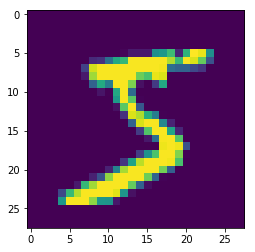

In [5]:
plt.imshow(train_data[0,:,:])
plt.show();

In [6]:
img_rows, img_cols = 28, 28

In [7]:
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

In [8]:
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data /= 255
test_data /= 255

In [9]:
train_labels.shape

(60000,)

In [10]:
test_data.shape

(10000, 28, 28, 1)

In [11]:
test_labels.shape

(10000,)

In [12]:
VALIDATION_SIZE = 5000  # Size of the validation set.

# Generate a validation set.
validation_data = train_data[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE]
train_data = train_data[VALIDATION_SIZE:, ...]
train_labels = train_labels[VALIDATION_SIZE:]

```
tf.nn.conv2d(
    input,
    filter,
    strides,
    padding,
    use_cudnn_on_gpu=None,
    data_format=None,
    name=None
)
```

`input` is assumed to be a tensor of shape `(batch, height, width, channels)` where `batch` is the number of images in a minibatch.

The argument `filter` is a tensor of shape `(filter_height, filter_width, channels, out_channels)`

`strides` contains the filter strides and is a list of length 4 (one for each input dimension).

```
tf.nn.max_pool(
    value,
    ksize,
    strides,
    padding,
    data_format='NHWC',
    name=None
)
```

`value` has the same shape as input for `tf.nn.conv2d`, `(batch, height, width, channels)`. `ksize` is the size of the pooling window and is a list of length 4. `strides` and `padding` behave as for `tf.nn.conv2d`.

Let’s define the weights needed to train our LeNet-5 network.

In [13]:
NUM_CHANNELS = 1
IMAGE_SIZE = 28
NUM_LABELS = 10
SEED = 66478  # Set to None for random seed.

In [15]:
graph = tf.Graph()

with graph.as_default():
        # This is where training samples and labels are fed to the graph.
        # These placeholder nodes will be fed a batch of training data at each
        # training step using the {feed_dict} argument to the Run() call below.

        conv1_weights = tf.Variable(
            tf.truncated_normal([5, 5, NUM_CHANNELS, 32],  # 5x5 filter, depth 32.
                                stddev=0.1,
                                seed=SEED, dtype=tf.float32), name='conv1_weights')
        
        conv1_biases = tf.Variable(tf.zeros([32], dtype=tf.float32), name='conv1_biases')

        conv2_weights = tf.Variable(tf.truncated_normal(
                                [5, 5, 32, 64], stddev=0.1, # 5x5 filter, depth 64, number channel 32
                                seed=SEED, dtype=tf.float32), name='conv2_weights')
        
        conv2_biases = tf.Variable(tf.constant(0.1, shape=[64], dtype=tf.float32), name='conv2_biases')

In [16]:
with graph.as_default():
    fc1_weights = tf.Variable(  # fully connected, depth 512.
        tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * 64, 512],
                            stddev=0.1,
                            seed=SEED,
                            dtype=tf.float32), name='fc1_weights')
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[512], dtype=tf.float32), name='fc1_biases')
    fc2_weights = tf.Variable(tf.truncated_normal([512, NUM_LABELS],
                                                  stddev=0.1,
                                                  seed=SEED,
                                                  dtype=tf.float32), name='fc2_weights')
    fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS], dtype=tf.float32), name='fc2_biases')

In [17]:
def model(data, train=False):
    """The Model definition."""
    with graph.as_default():
        # 2D convolution, with 'SAME' padding (i.e. the output feature map has
        # the same size as the input). Note that {strides} is a 4D array whose
        # shape matches the data layout: [image index, y, x, depth].
        conv = tf.nn.conv2d(data,
                          conv1_weights,
                          strides=[1, 1, 1, 1],
                          padding='SAME')
        # Bias and rectified linear non-linearity.
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        # Max pooling. The kernel size spec {ksize} also follows the layout of
        # the data. Here we have a pooling window of 2, and a stride of 2.
        pool = tf.nn.max_pool(relu,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')

        conv = tf.nn.conv2d(pool,
                          conv2_weights,
                          strides=[1, 1, 1, 1],
                          padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')

        # Reshape the feature map cuboid into a 2D matrix to feed it to the
        # fully connected layers.
        pool_shape = pool.get_shape().as_list()
        reshape = tf.reshape(
            pool,
            [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])

        # Fully connected layer. Note that the '+' operation automatically
        # broadcasts the biases.
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

        # Add a 50% dropout during training only. Dropout also scales
        # activations such that no rescaling is needed at evaluation time.
        if train:
            hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)

        # output dot product + bias =  fc layer
        return tf.matmul(hidden, fc2_weights) + fc2_biases

In [18]:
BATCH_SIZE = 64
EVAL_BATCH_SIZE = 64

with graph.as_default():
    train_data_node = tf.placeholder(
        tf.float32,
        shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), name='train_data_node')
    
    train_labels_node = tf.placeholder(tf.int64, shape=(BATCH_SIZE,), name='train_labels_node')
    
    eval_data = tf.placeholder(
        tf.float32,
        shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), name='eval_data')


In [19]:
NUM_EPOCHS = 10
EVAL_BATCH_SIZE = 64
EVAL_FREQUENCY = 100  # Number of steps between evaluations.

num_epochs = NUM_EPOCHS
train_size = train_labels.shape[0]

In [20]:
with graph.as_default():
    # Training computation: logits + cross-entropy loss.
    logits = model(train_data_node, True)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=train_labels_node, logits=logits))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(fc1_weights)
                    + tf.nn.l2_loss(fc1_biases)
                    + tf.nn.l2_loss(fc2_weights)
                    + tf.nn.l2_loss(fc2_biases))
    # Add the regularization term to the loss.
    loss += 5e-4 * regularizers

    # Optimizer: set up a variable that's incremented once per batch and
    # controls the learning rate decay.
    batch = tf.Variable(0, dtype=tf.float32)
    
    # Decay once per epoch, using an exponential schedule starting at 0.01.
    learning_rate = tf.train.exponential_decay(
        0.01,                # Base learning rate.
        batch * BATCH_SIZE,  # Current index into the dataset.
        train_size,          # Decay step.
        0.95,                # Decay rate.
        staircase=True)
    
    # Use simple momentum for the optimization.
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    # Predictions for the current training minibatch.
    train_prediction = tf.nn.softmax(logits)

    # Predictions for the test and validation, which we'll compute less
    # often.
    eval_prediction = tf.nn.softmax(model(eval_data))

In [21]:
def error_rate(predictions, labels):
    """Return the error rate based on dense predictions and sparse labels."""
    return 100.0 - (
      100.0 *
      np.sum(np.argmax(predictions, 1) == labels) /
      predictions.shape[0])

In [22]:
# Small utility function to evaluate a dataset by feeding batches of
# data to {eval_data} and pulling the results from {eval_predictions}.
# Saves memory and enables this to run on smaller GPUs.
def eval_in_batches(data, sess):
    """Get predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
        raise ValueError("batch size for evals larger than dataset: %d"
                     % size)
    predictions = np.ndarray(shape=(size, NUM_LABELS), dtype=np.float32)
    
    for begin in range(0, size, EVAL_BATCH_SIZE):
        end = begin + EVAL_BATCH_SIZE
        if end <= size:
            predictions[begin:end, :] = sess.run(
              eval_prediction,
              feed_dict={eval_data: data[begin:end, ...]})
            
        else:
            batch_predictions = sess.run(
              eval_prediction,
              feed_dict={eval_data: data[-EVAL_BATCH_SIZE:, ...]})
            
            predictions[begin:, :] = batch_predictions[begin - size:, :]
    return predictions

In [24]:
# Create a local session to run the training.
start_time = time.time()
with tf.Session(graph=graph) as sess:
  # Run all the initializers to prepare the trainable parameters.
  sess.run(tf.global_variables_initializer())
    
  # Loop through training steps.
  for step in range(600):
    # Compute the offset of the current minibatch in the data.
    # Note that we could use better randomization across epochs.
    offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
    
    batch_data = train_data[offset:(offset + BATCH_SIZE), ...]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    
    # This dictionary maps the batch data (as a NumPy array) to the
    # node in the graph it should be fed to.
    feed_dict = {train_data_node: batch_data,
                 train_labels_node: batch_labels}
    # Run the optimizer to update weights.
    sess.run(optimizer, feed_dict=feed_dict)
    
    # print some extra information once reach the evaluation frequency
    if step % EVAL_FREQUENCY == 0:
        # fetch some extra nodes' data
        l, lr, predictions = sess.run([loss, learning_rate,
                                     train_prediction],
                                    feed_dict=feed_dict)
        elapsed_time = time.time() - start_time
        start_time = time.time()
        print('Step %d (epoch %.2f), %.1f ms' %
            (step, float(step) * BATCH_SIZE / train_size,
             1000 * elapsed_time / EVAL_FREQUENCY))
        print('Minibatch loss: %.3f, learning rate: %.6f' % (l, lr))
        print('Minibatch error: %.1f%%'
            % error_rate(predictions, batch_labels))
        print('Validation error: %.1f%%' % error_rate(
          eval_in_batches(validation_data, sess), validation_labels))
        sys.stdout.flush()
        
    # Finally print the result!
    test_error = error_rate(eval_in_batches(test_data, sess),
                          test_labels)
    print('Test error: %.1f%%' % test_error)

Step 0 (epoch 0.00), 4.4 ms
Minibatch loss: 8.280, learning rate: 0.010000
Minibatch error: 84.4%
Validation error: 76.8%
Test error: 77.7%
Test error: 76.0%
Test error: 83.0%
Test error: 80.5%
Test error: 73.7%
Test error: 75.0%
Test error: 74.2%
Test error: 71.5%
Test error: 71.4%
Test error: 73.8%
Test error: 74.8%
Test error: 74.5%
Test error: 71.7%
Test error: 68.0%
Test error: 63.1%
Test error: 58.6%
Test error: 57.1%
Test error: 54.3%
Test error: 47.2%
Test error: 41.2%
Test error: 39.5%
Test error: 39.1%
Test error: 37.2%
Test error: 35.0%
Test error: 33.5%
Test error: 32.2%
Test error: 31.5%
Test error: 29.2%
Test error: 26.7%
Test error: 23.3%
Test error: 21.4%
Test error: 20.2%
Test error: 19.3%
Test error: 18.1%
Test error: 17.0%
Test error: 17.4%
Test error: 17.7%
Test error: 17.5%
Test error: 15.7%
Test error: 16.3%
Test error: 17.7%
Test error: 17.2%
Test error: 15.8%
Test error: 14.9%
Test error: 14.0%
Test error: 13.1%
Test error: 13.4%
Test error: 14.5%
Test error: 14